In [1]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import corner

In [2]:
import jax 
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.nn import relu, elu
import optax 

from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [3]:
data = pd.read_csv('Data/mesa_data.csv')
data.head()

Unnamed: 0  filename  model_number  evol_stage  initial_mass  \
0           0  profile4         152.0         0.0           0.8   
1           1  profile5         153.0         0.0           0.8   
2           2  profile6         154.0         0.0           0.8   
3           3  profile7         155.0         0.0           0.8   
4           4  profile8         156.0         0.0           0.8   

   initial_Yinit  initial_Zinit  initial_feh  initial_MLT  initial_fov  ...  \
0           0.32       0.036803          0.5          2.1          0.0  ...   
1           0.32       0.036803          0.5          2.1          0.0  ...   
2           0.32       0.036803          0.5          2.1          0.0  ...   
3           0.32       0.036803          0.5          2.1          0.0  ...   
4           0.32       0.036803          0.5          2.1          0.0  ...   

     E_0_36    E_0_37    E_0_38        E_0_39        E_0_40        tau_he  \
0  0.000006  0.000002  0.000001  7.889056e-07  6.149682e-07  15247.850269   
1  0.000008  0.000002  0.000001  8.212464e-07  6.273383e-07  14809.891105   
2  0.000013  0.000003  0.000001  8.515127e-07  6.398741e-07  14496.838617   
3  0.000018  0.000003  0.000001  8.790797e-07  6.513090e-07  14220.559706   
4  0.000027  0.000003  0.000001  9.036751e-07  6.612813e-07  14054.932771   

      delta_he    amp_he        tau_cz  \
0  2037.139686  0.029961  38796.631185   
1  1980.528826  0.029540  37900.327592   
2  1940.585790  0.029221  37222.634389   
3  1878.217087  0.028561  36703.539749   
4  1883.449431  0.028860  36302.082709   

                                            dirname  
0  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
1  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
2  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
3  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
4  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  

[5 rows x 116 columns]

In [4]:
print(len(data))
data = data[data.star_age > 0.2]
data = data[data.effective_T < 6800]
data = data[data.nu_max > 600]
len(data)

253072


59785

In [5]:
icols = ['initial_mass',
 'initial_Yinit',
 'initial_feh',
 'initial_MLT',
 'frac_age']

ocols = ['luminosity',
 'radius',
 'delta_nu',
 'nu_max']

fcols = [f'nu_0_{n}' for n in range(12, 28)]

cols = fcols + icols + ocols

dfc = data.copy()
dfc.loc[:, ocols + fcols] = onp.log10(data[ocols + fcols])
dfc = dfc[cols]

In [6]:
xs = dfc[icols].values
ys = dfc[fcols + ocols].values

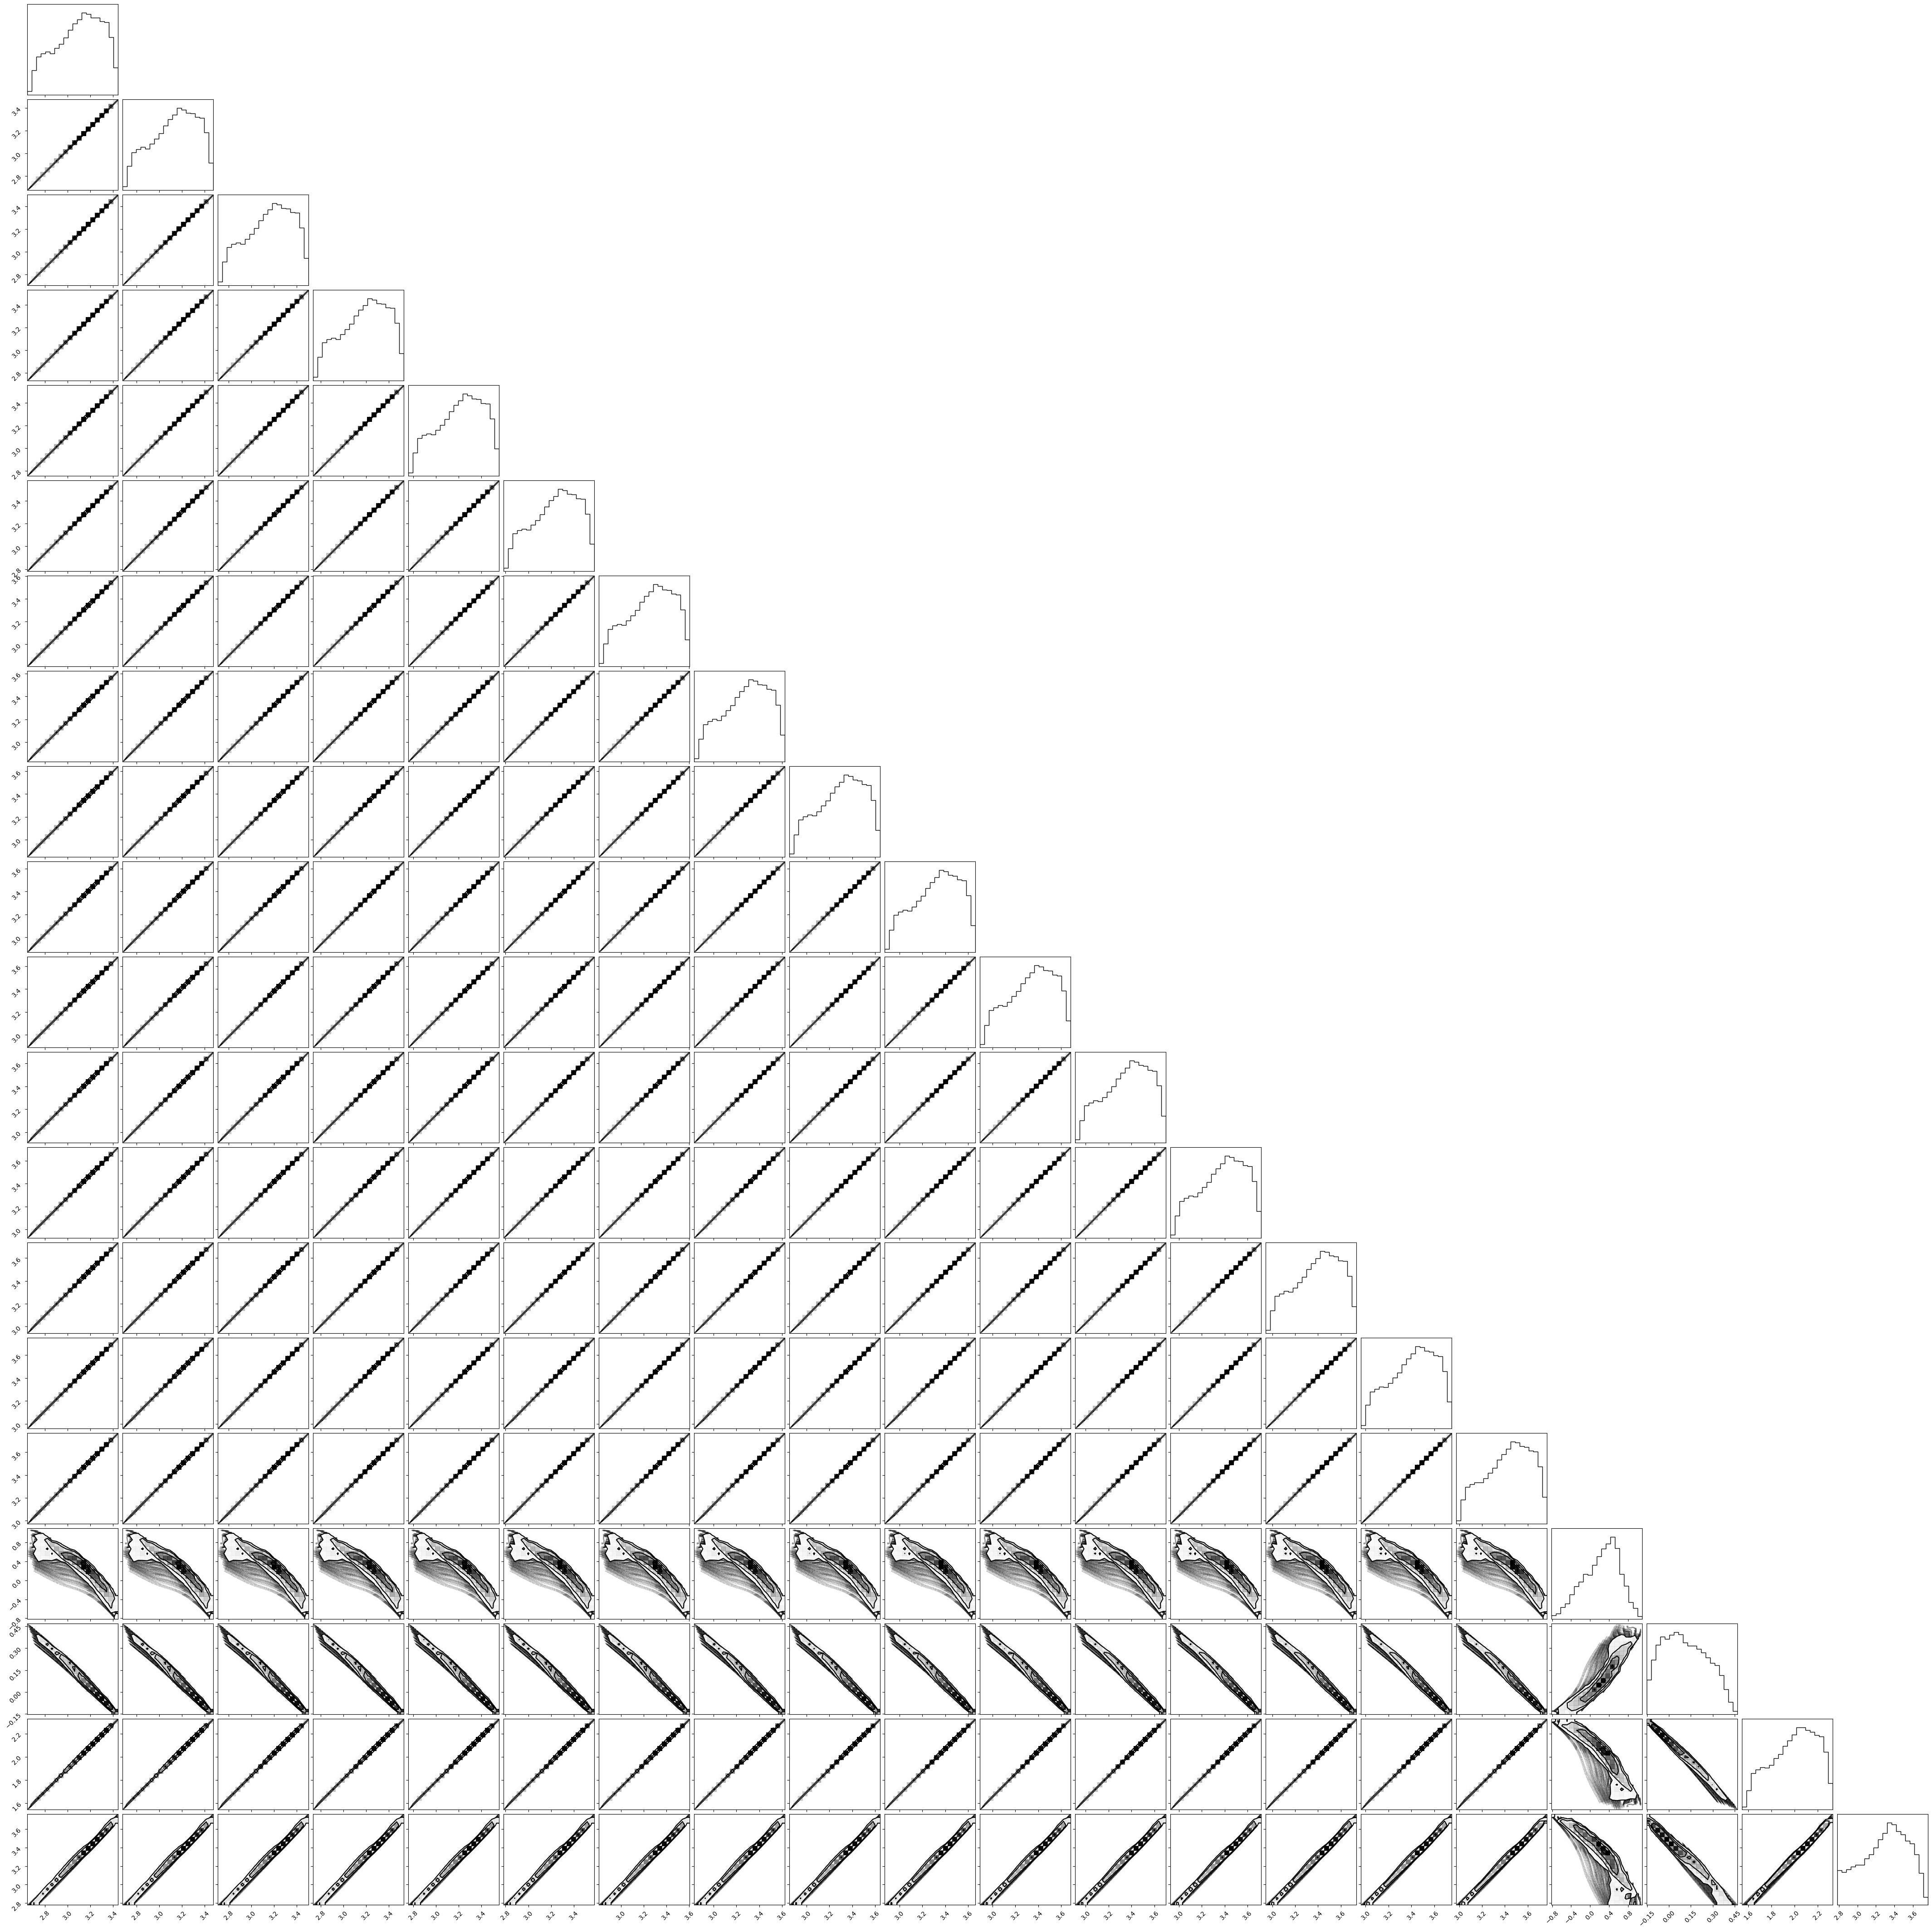

In [7]:
corner.corner(ys);

In [8]:
from functools import partial

class pcann():
    def __init__(self, 
                 layer_sizes=[3, 5, 5, 2], 
                 key=random.PRNGKey(1)):
        self.params = self.initialize_mlp(layer_sizes, key)
        self.batch_forward = vmap(self.forward_pass, in_axes=(None, 0))
        
        
    def init_pca(self, n_components=4):
        self.pca = PCA(n_components=n_components)
        
    def fit_pca(self, ys):
        self.pca.fit(ys)
        print(f'PCA explained variance : {self.pca.explained_variance_ratio_}')
        print(f'PCA total explained variance : {sum(self.pca.explained_variance_ratio_)}')
        self.pca_comp = self.pca.components_
        self.pca_mean = self.pca.mean_
    
    def train(self, xs, ys, 
              lr=1e-1,
              epochs=100, 
              verbose=True,
              recompile=True):
        if recompile:
            self.initialize_opt(lr=lr)
        for i in range(epochs):
            grads = jax.grad(self.loss)(self.params, xs, ys)
            updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
            self.params = optax.apply_updates(self.params, updates)
            if i%(epochs / 10) == 0 and verbose:
                print(f'Epoch {i}: Loss is {self.loss(self.params, xs, ys)}')
        
    def initialize_opt(self, lr=2e-2):
        self.optimizer = optax.adam(lr, b1=0.999)
        #self.optimizer = optax.sgd(lr)
        self.opt_state = self.optimizer.init(self.params)
        
    def pred(self, params, x):
        return self.batch_forward(params, x)
        
    @partial(jit, static_argnums=(0,))
    def loss(self, params, x, y):
        preds = self.pred(params, x)
        loss = np.mean(optax.l2_loss(preds, y))
        return loss
        
    def forward_pass(self, params, x):
        """ Compute the forward pass for each example individually """
        activations = x

        # Loop over the hidden layers
        for w, b in params[:-1]:
            outputs = np.dot(w, activations) + b  # apply affine transformation
            activations = elu(outputs)  #  apply nonlinear activation

        # Perform final mlp output
        w, b = params[-1]
        outputs = (np.dot(w, activations) + b)
        
        # Add pca inverse transform to the output
        final_outputs = np.dot(outputs, self.pca_comp) + self.pca_mean
        return final_outputs
        
    def initialize_mlp(self, sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [9]:
pca_n_comps = 5
nn = pcann(layer_sizes = [len(icols), 64, 64, 64, 64, pca_n_comps])
nn.init_pca(n_components=pca_n_comps)
nn.fit_pca(ys)

PCA explained variance : [9.62323247e-01 3.67255084e-02 8.67652006e-04 7.98313647e-05
 1.79562271e-06]
PCA total explained variance : 0.999998034168632


In [10]:
%%time
nn.train(np.asarray(xs), np.asarray(ys), lr=5e-4, epochs=2000)

Epoch 0: Loss is 0.021376390010118484
Epoch 200: Loss is 0.0051938630640506744
Epoch 400: Loss is 0.0044333441182971
Epoch 600: Loss is 0.005023005418479443
Epoch 800: Loss is 0.004043790511786938
Epoch 1000: Loss is 0.003444947302341461
Epoch 1200: Loss is 0.0037659246008843184
Epoch 1400: Loss is 0.00342864659614861
Epoch 1600: Loss is 0.0033369832672178745
Epoch 1800: Loss is 0.0034323525615036488
CPU times: user 7min 27s, sys: 1min 2s, total: 8min 30s
Wall time: 3min 13s


In [11]:
preds = nn.pred(nn.params, xs)

0.0704151
0.03313851356506348
0.0331568717956543
0.03314828872680664
0.03303956985473633
0.03292703628540039
0.03281450271606445
0.03275156021118164
0.03270769119262695
0.032623291015625
0.0325472354888916
0.03249168395996094
0.032457828521728516
0.03242611885070801
0.0323948860168457
0.032402753829956055
0.03241539001464844
0.12686610221862793
0.02763337641954422
0.031891465187072754
0.04382157325744629


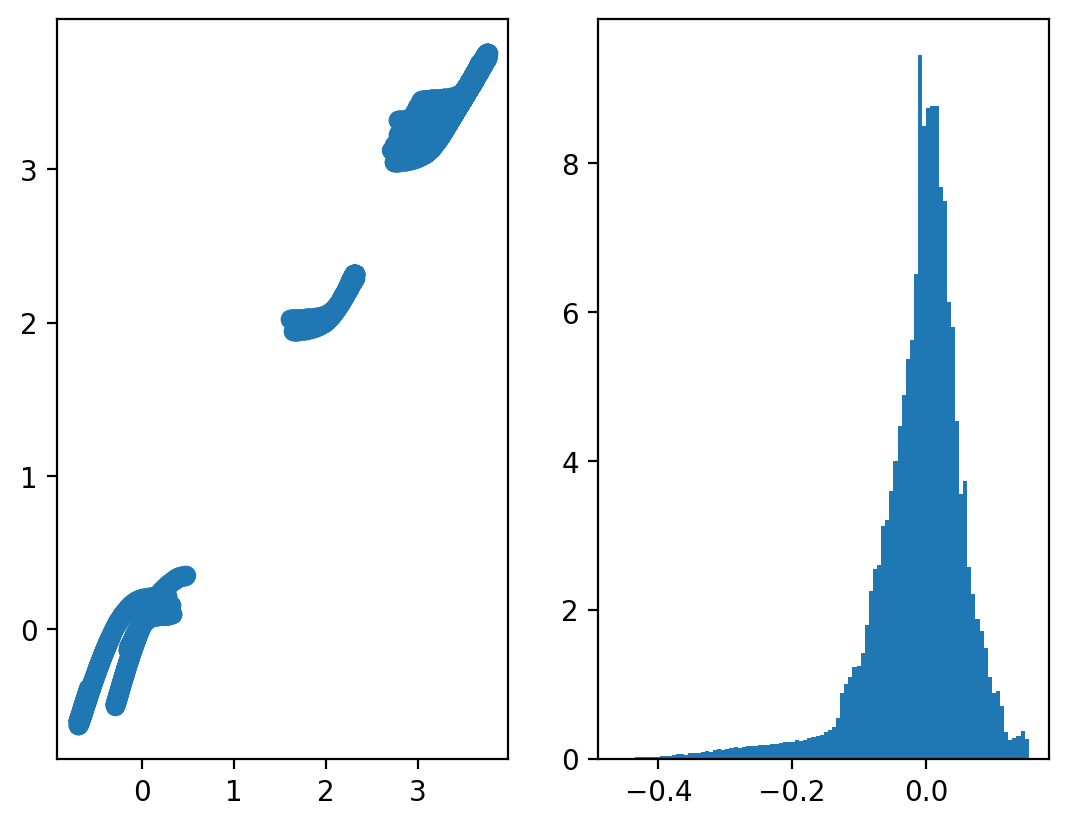

In [12]:
fig, ax = plt.subplots(1, 2, dpi=200)

n = 1000

ax[0].scatter(ys[:n, ...], preds[:n, ...])

ax[1].hist(onp.array(ys[:, 1] - preds[:, 1]), bins=100, density=True);
print(onp.std(onp.array(ys[:, 1] - preds[:, 1])))

from scipy import stats
for i in range(len(ys[0, :])):
    print(stats.median_abs_deviation(onp.array(ys[:, i] - preds[:, i])))

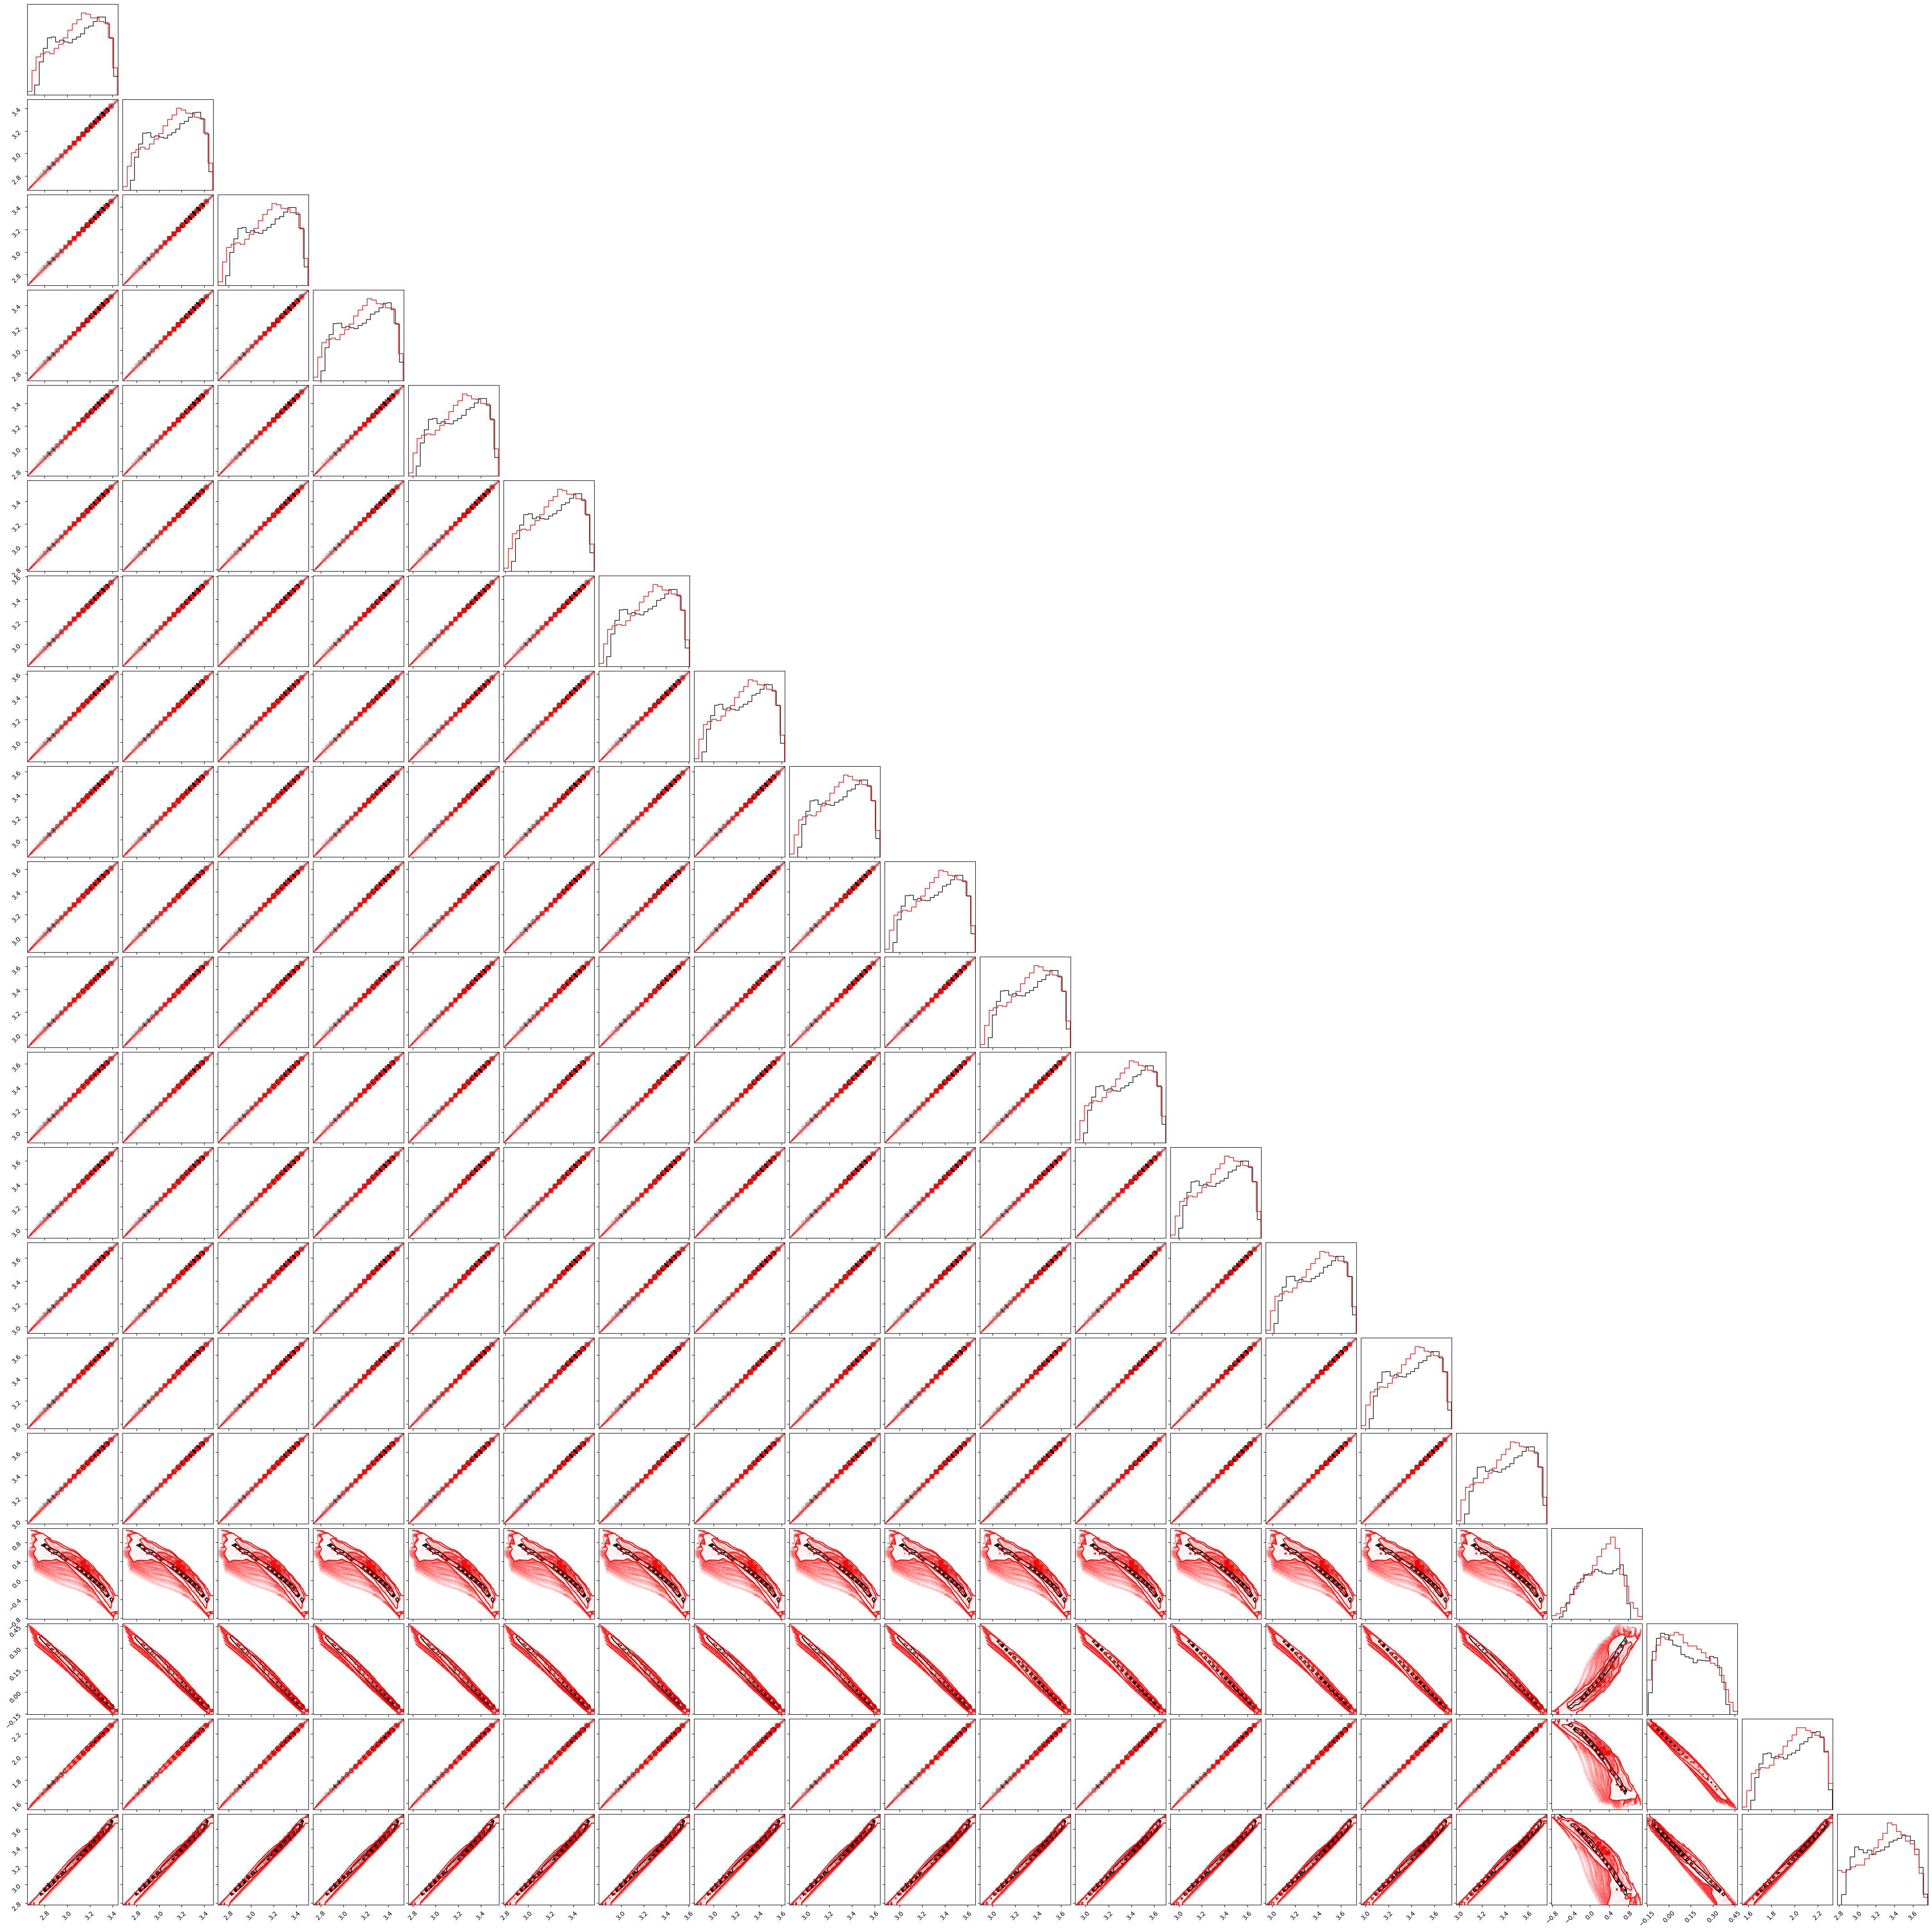

In [13]:
fig = corner.corner(onp.array(preds), color='k');
corner.corner(onp.array(ys), fig=fig, color='r');

In [14]:
nn.train(np.asarray(xs), np.asarray(ys), epochs=3000, recompile=False)

Epoch 0: Loss is 0.0032401722855865955
Epoch 300: Loss is 0.0030949306674301624
Epoch 600: Loss is 0.0030431339982897043
Epoch 900: Loss is 0.0029764275532215834
Epoch 1200: Loss is 0.0029463779646903276
Epoch 1500: Loss is 0.0027744020335376263
Epoch 1800: Loss is 0.0024604597128927708
Epoch 2100: Loss is 0.0023411563597619534
Epoch 2400: Loss is 0.002302573062479496
Epoch 2700: Loss is 0.0022435213904827833


In [15]:
print(nn.params)

[(DeviceArray([[-0.20172368, -0.28077456,  0.04381921,  0.00215547,
              -0.07818818],
             [-0.1689878 , -0.09246082,  0.02395324,  0.04012122,
              -0.14117247],
             [ 0.2066228 ,  0.26491323, -0.0858359 ,  0.02573321,
               0.01316986],
             [ 0.19286741,  0.16458455, -0.05546068, -0.02237423,
               0.13263807],
             [-0.22437741, -0.25228623,  0.05369783,  0.00637034,
              -0.08940051],
             [ 0.17996727,  0.27310437, -0.05244894, -0.0210903 ,
               0.16088921],
             [-0.20084822, -0.26213357,  0.08674546, -0.02150059,
              -0.02432079],
             [ 0.18782213,  0.25315607, -0.05792542, -0.00647357,
               0.1439728 ],
             [-0.21676907, -0.21642017,  0.03792986,  0.01578953,
              -0.10777993],
             [-0.19470093, -0.2280261 ,  0.07168619, -0.00767394,
              -0.0701368 ],
             [ 0.19059268,  0.2699342 , -0.06070629, -0.00

[0.8        0.32       0.5        2.1        0.00986245]


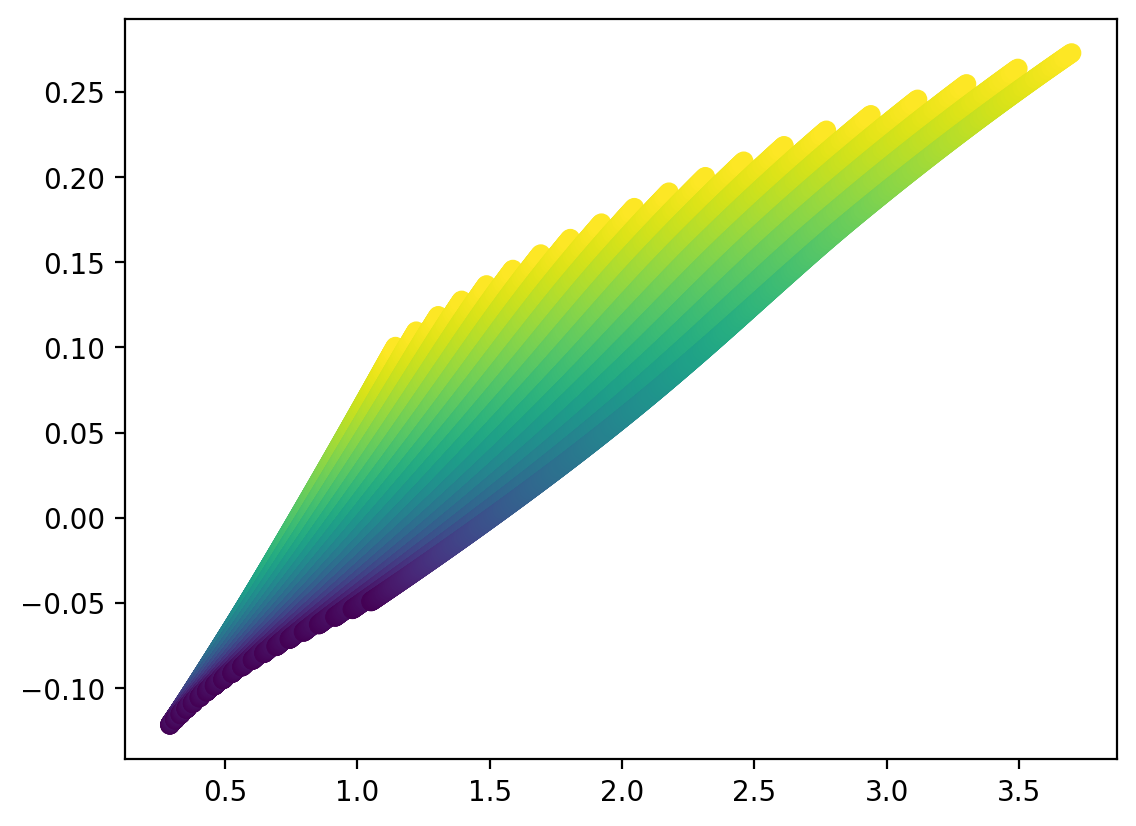

In [18]:
print(xs[0, :])
fage = onp.arange(0, 1.1, 0.001)
fig, ax = plt.subplots(dpi=200)

for m in np.arange(0.8, 1.2, 0.02):
    isoinput = [[m, 0.27, 0.0, 2.1, n] for n in fage]
    isochrone = nn.pred(nn.params, np.asarray(isoinput))


    ax.scatter(10**(isochrone[:, -4]), isochrone[:, -3], c=fage)
#ax.set_xlim([6400, 5000])